# 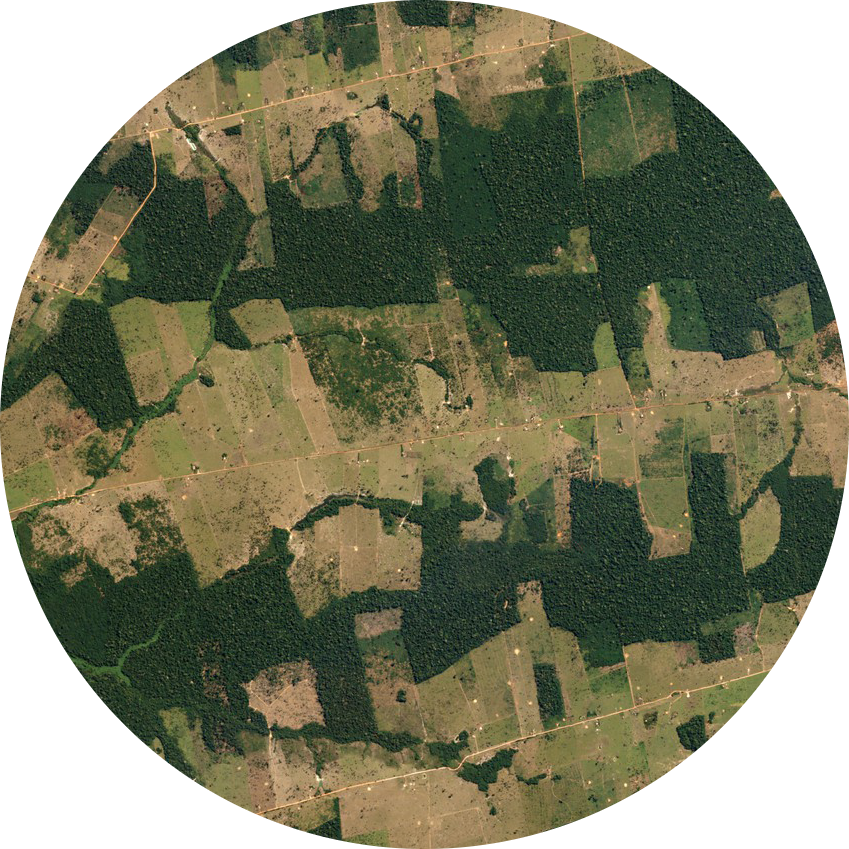

# # **Planet: Understanding the Amazon from Space**

**Table of Contents**
1. Introduction
2. Import Libraries
3. Data Wrangling
4. Exploratory Data Analysis
5. Bulding Model
6. Model Training and Evaluation

# **Introduction**

Every minute, the world loses an area of forest the size of 48 football fields. And deforestation in the Amazon Basin accounts for the largest share, contributing to reduced biodiversity, habitat loss, climate change, and other devastating effects. But better data about the location of deforestation and human encroachment on forests can help governments and local stakeholders respond more quickly and effectively.

Planet, designer and builder of the world’s largest constellation of Earth-imaging satellites, will soon be collecting daily imagery of the entire land surface of the earth at 3-5 meter resolution. While considerable research has been devoted to tracking changes in forests, it typically depends on coarse-resolution imagery from Landsat (30 meter pixels) or MODIS (250 meter pixels). This limits its effectiveness in areas where small-scale deforestation or forest degradation dominate.

Furthermore, these existing methods generally cannot differentiate between human causes of forest loss and natural causes. Higher resolution imagery has already been shown to be exceptionally good at this, but robust methods have not yet been developed for Planet imagery.

# **Import Libraries**

In [1]:
import pandas as pd
import numpy as np

# Libraries for Data Visualisation
import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib.image import imread
%matplotlib inline

# Libraries for Loading and Preparing dataset
from os import listdir
from numpy import zeros
from numpy import asarray
from numpy import savez_compressed
from pandas import read_csv
from keras import backend
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import os
import time
from sklearn.metrics import fbeta_score
import tensorflow as tf
from keras.optimizers import SGD
import sys
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Conv2D, Input
from keras.layers import MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split

from keras import optimizers
from keras.callbacks import EarlyStopping,ModelCheckpoint 
from keras import backend as K 
import tensorflow.keras as keras
from tensorflow.keras.applications.vgg16 import VGG16

from tensorflow.python import metrics
from tensorflow.keras.layers import Dropout
from tensorflow.keras.utils import to_categorical

import gc                             
import cv2
import pickle
from tqdm import tqdm_notebook as tqdm

from sklearn.manifold import TSNE
from scipy.spatial.distance import pdist, squareform
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

import plotly.tools as tls
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
from collections import Counter, defaultdict

print("Setup Completed...!!!")

Setup Completed...!!!


In [3]:
# Loading the train and test datasets

path_train = '../input/planets-dataset/planet/planet/train_classes.csv'
path_test = '../input/planets-dataset/planet/planet/sample_submission.csv'

planet_df_train = pd.read_csv(path_train)
planet_df_test = pd.read_csv(path_test)

planet_test_image = '../input/planets-dataset/planet/planet/test-jpg/'
planet_train_image = '../input/planets-dataset/planet/planet/train-jpg/'

# **Data Wrangling**

In [4]:
planet_df_train.head()

image_name                                       tags
0    train_0                               haze primary
1    train_1            agriculture clear primary water
2    train_2                              clear primary
3    train_3                              clear primary
4    train_4  agriculture clear habitation primary road

In [5]:
planet_df_test.head()

image_name                                  tags
0     test_0  primary clear agriculture road water
1     test_1  primary clear agriculture road water
2     test_2  primary clear agriculture road water
3     test_3  primary clear agriculture road water
4     test_4  primary clear agriculture road water

In [6]:
print('There are Total of {} images contains in train_classes.csv file'.format(len(planet_df_train)))

There are Total of 40479 images contains in train_classes.csv file


In [7]:
print("There are {} rows and {} columns in the train_classes.csv.".format(planet_df_train.shape[0], planet_df_train.shape[1]))

There are 40479 rows and 2 columns in the train_classes.csv.


In [8]:
# Create a series of tags, each observation split into multiple strings
tags = planet_df_train['tags'].apply(lambda x: x.split(' '))

# Create a list of all occuring, non-unique tags
all_tags = [item for sublist in list(planet_df_train['tags'].apply(lambda row: row.split(" ")).values) for item in sublist]

all_tags[:7]

['haze', 'primary', 'agriculture', 'clear', 'primary', 'water', 'clear']

In [9]:
print('There are total of {} non-unique tags in all training images'.format(len(all_tags)))

print('The average number of tags per image is {}'.format(1.0*len(all_tags)/planet_df_train.shape[0]))

There are total of 116278 non-unique tags in all training images
The average number of tags per image is 2.8725511993873365


In [10]:
missing_values = pd.DataFrame({'Count':planet_df_train.isna().sum(),'Percentage':planet_df_train.isna().sum()/len(planet_df_train)*100})
missing_values

Count  Percentage
image_name      0         0.0
tags            0         0.0

# **Exploratory Data Analysis**

We need to define a function that would allow us to display .jpe images

In [11]:
# Function to fetch the tags of an image
def fetch_image_tag(img):
    
    tags = planet_df_train[planet_df_train['image_name'] == img]['tags'].values
    
    return tags[0]

In [12]:
#display the corresponding 'train_551' image_name and tags from planet_df_train dataframe

planet_df_train[planet_df_train['image_name'] == 'train_551']

image_name                   tags
551  train_551  partly_cloudy primary

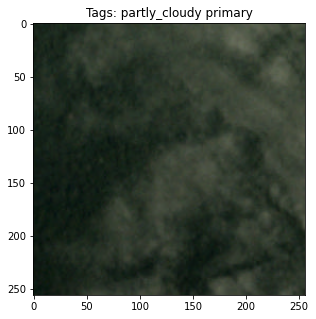

In [13]:
#Let display a single image using from teh training data


plt.figure(figsize=(8,5))
filename = planet_train_image + 'train_551.jpg'
image = imread(filename)   # load image pixels
pyplot.imshow(image)       # plot the image
plt.title('Tags: ' + fetch_image_tag('train_551'))
pyplot.show()

In [14]:
#let try another image
planet_df_train[planet_df_train['image_name'] == 'train_10']

image_name                                        tags
10   train_10  agriculture clear primary slash_burn water

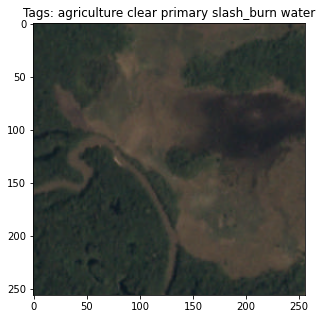

In [15]:
#show image 'train_10'

plt.figure(figsize=(8,5))
filename = planet_train_image + 'train_10.jpg'
image = imread(filename)   # load image pixels
pyplot.imshow(image)       # plot the image
plt.title('Tags: ' + fetch_image_tag('train_10'))
pyplot.show()

Now, let load multiple images, and their corresponding labels.

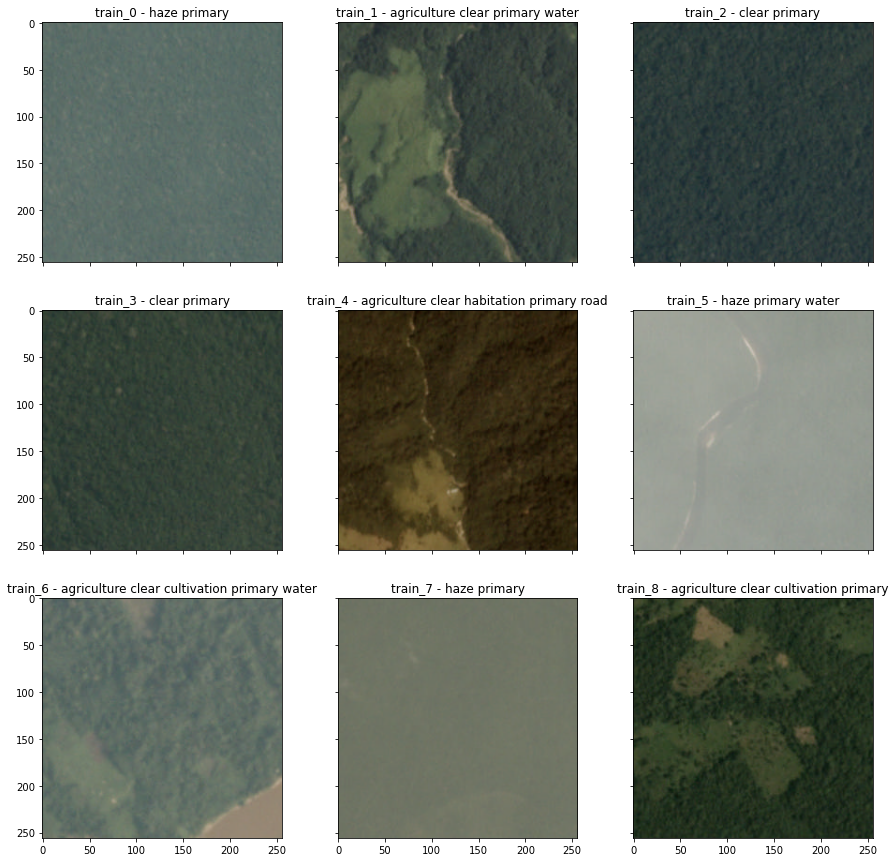

In [16]:
new_style = {'grid': False}
plt.rc('axes', **new_style)

_, ax = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(15, 15))
i = 0
for f, l in planet_df_train[:9].values:
    #img = io.imread(folder)
    img = cv2.imread('../input/planets-dataset/planet/planet/train-jpg/{}.jpg'.format(f))
    ax[i // 3, i % 3].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax[i // 3, i % 3].set_title('{} - {}'.format(f, l))
    #ax[i // 4, i % 4].show()
    i += 1
    
plt.show()

# **Bulding The Model**

In [17]:
# Flatten the 'tags' column of the training dataset into a list
flatten = lambda l: [item for sublist in l for item in sublist]
labels = list (set(flatten([l.split (' ') for l in planet_df_train['tags'].values])))

In [18]:
# Organizing a label mapping
label_map = {l: i for i, l in enumerate(labels)}
inv_label_map = {i: l for l, i in label_map.items()}
label_map


{'partly_cloudy': 0,
 'slash_burn': 1,
 'road': 2,
 'conventional_mine': 3,
 'artisinal_mine': 4,
 'selective_logging': 5,
 'cultivation': 6,
 'agriculture': 7,
 'habitation': 8,
 'cloudy': 9,
 'blooming': 10,
 'haze': 11,
 'blow_down': 12,
 'bare_ground': 13,
 'water': 14,
 'clear': 15,
 'primary': 16}

In [19]:
gc.collect() # Used frequently to avoid session crashing due to memory exhaustion

4739

In [20]:
# Reading in the train image dataset
x_train= []
y_train= []
for img, label in tqdm(planet_df_train.values, miniters = 1000):
    target = np.zeros(17)
  
  # We create the 17-dimensional binary label vectors i.e One-hot encoding it
    for tag in label.split(' '):
        target[label_map[tag]]=1
  
  # Reshaping and assigning to arbitrary variables
    x_train.append(cv2.resize(cv2.imread('../input/planets-dataset/planet/planet/train-jpg/{}.jpg'.format(img)), (64,64)))
    y_train.append(target)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



In [21]:
print(len(x_train)) 

40479


In [22]:
gc.collect()

47

In [23]:
x_test = []

for img, label in tqdm(planet_df_test[0:40669].values, miniters=1000):
    fil = cv2.resize(cv2.imread('../input/planets-dataset/planet/planet/test-jpg/{}.jpg'.format(img)), (64, 64))
    x_test.append(fil)

for img, label in tqdm(planet_df_test[40669:].values, miniters=1000):
    fil = cv2.resize(cv2.imread('../input/planets-dataset/test-jpg-additional/test-jpg-additional/{}.jpg'.format(img)), (64, 64))
    x_test.append(fil)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



In [24]:
print("The lenght of x test: ", len(x_test))

The lenght of x test:  61191


In [25]:
gc.collect()

50

In [26]:
#Change lists to numpy arrays and normalize

x_train = np.array(x_train, np.float16)/255.
y_train = np.array(y_train, np.uint8)
x_test = np.array(x_test, np.float16)/255.

In [27]:
# Splitting the training dataset into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.3, train_size = 0.7, shuffle = True, random_state = 42)

In [28]:
#Let view the shape of the splitted datasets

print("Training dataset")
print(x_train.shape)
print(y_train.shape)
print("=" * 20)
print("Validation dataset")
print(x_val.shape)
print(y_val.shape)

Training dataset
(28335, 64, 64, 3)
(28335, 17)
Validation dataset
(12144, 64, 64, 3)
(12144, 17)


**CNN Architecture**

In [30]:
input_size = 64
input_channels = 3


#define model
cnn_model = Sequential()

#Input layer
cnn_model.add(BatchNormalization(input_shape=(input_size, input_size, input_channels)))

# CCM_1
cnn_model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'))
cnn_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))

#CCM_2
cnn_model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
cnn_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))
 
#CCM_3
cnn_model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
cnn_model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))
 
#CCM_4
cnn_model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
cnn_model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))

# Create a feature vector from the CCM_4 final layer
cnn_model.add(Flatten())

# Fully Connected (FC) Layer
cnn_model.add(Dense(512, activation='relu'))
cnn_model .add(BatchNormalization())
cnn_model.add(Dropout(0.5))

# Output layer
cnn_model.add(Dense(17, activation='sigmoid'))


In [31]:
# Extract the pre - trained architecture
base_model = VGG16(input_shape =(input_size,input_size,3),include_top =False,weights ='imagenet')
base_model.summary()


58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
______________________________________________________________

In [32]:
# Get the output of the base_model formed above
x = base_model.output
# Flatten to obtain a feature vector
x = Flatten()(x)
# Connect the feature vector to to the fully connected (FC) layer
x = Dense(512 , activation ='relu')(x)
# Form the output label predictions
predictions = Dense (17 , activation ='sigmoid')(x)
cnn_model = Model(inputs= base_model.input,outputs = predictions)

In [33]:
gc.collect()

22

# **Model Training and Evaluation**

In [34]:
def fbeta(y_true, y_pred, threshold_shift=0):
    beta = 2
 
    # just in case of hipster activation at the final layer
    y_pred = K.clip(y_pred, 0, 1)
 
    # shifting the prediction threshold from .5 if needed
    y_pred_bin = K.round(y_pred + threshold_shift)
 
    tp = K.sum(K.round(y_true * y_pred_bin)) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))
 
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
 
    beta_squared = beta ** 2
    return (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())


In [35]:
gc.collect()

44

In [36]:
# Implementing ImageDataGenerator for data augmentation. 
Generator_Image = ImageDataGenerator ( horizontal_flip =True , vertical_flip =True, 
                              zoom_range =0.2, rotation_range =90, 
                              fill_mode ='reflect')

#Other parameters
epochs = 25 
opt = keras.optimizers.Adam(learning_rate=0.0001)

#model compiling
cnn_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[fbeta])

callbacks = [EarlyStopping(monitor='val_loss', patience=2, verbose=2)]


In [37]:
gc.collect()

22

In [38]:
# Let fit the model. The code below fits the model while generating extra images due to the Imagedatagenerator and fitting them on the fly!

cnn_model.fit_generator(Generator_Image.flow(x_train, y_train, batch_size = 32), 
                    steps_per_epoch =len(x_train)/32 , 
                    validation_data = Generator_Image.flow ( x_val, y_val, batch_size =32),
                    validation_steps =len(x_val)/32 ,
                    epochs =epochs , callbacks = callbacks ,
                    verbose = 2)


Epoch 1/25
886/885 - 52s - loss: 0.1460 - fbeta: 0.7967 - val_loss: 0.1207 - val_fbeta: 0.8236
Epoch 2/25
886/885 - 51s - loss: 0.1212 - fbeta: 0.8338 - val_loss: 0.1180 - val_fbeta: 0.8401
Epoch 3/25
886/885 - 51s - loss: 0.1136 - fbeta: 0.8455 - val_loss: 0.1119 - val_fbeta: 0.8545
Epoch 4/25
886/885 - 52s - loss: 0.1107 - fbeta: 0.8504 - val_loss: 0.1107 - val_fbeta: 0.8408
Epoch 5/25
886/885 - 51s - loss: 0.1075 - fbeta: 0.8547 - val_loss: 0.1080 - val_fbeta: 0.8678
Epoch 6/25
886/885 - 51s - loss: 0.1064 - fbeta: 0.8563 - val_loss: 0.1088 - val_fbeta: 0.8446
Epoch 7/25
886/885 - 52s - loss: 0.1050 - fbeta: 0.8586 - val_loss: 0.1038 - val_fbeta: 0.8624
Epoch 8/25
886/885 - 52s - loss: 0.1031 - fbeta: 0.8608 - val_loss: 0.1080 - val_fbeta: 0.8663
Epoch 9/25
886/885 - 52s - loss: 0.1026 - fbeta: 0.8623 - val_loss: 0.1049 - val_fbeta: 0.8609
Epoch 00009: early stopping


In [39]:
gc.collect()

97

In [40]:
test_predict =[]
test_predict.append (cnn_model.predict (x_test , batch_size = 128 , verbose =2) ) 


479/479 - 11s


In [41]:
gc.collect()

740

In [42]:
# After prediction, we compile the results in a pandas dataframe 
result = np.array (test_predict[0])
for i in range (1,len(test_predict) ):
    result += np. array (test_predict)

result = pd.DataFrame (result,columns = labels )
result

partly_cloudy  slash_burn      road  conventional_mine  artisinal_mine  \
0           0.002534    0.000023  0.005479       7.988632e-07        0.000015   
1           0.004406    0.000082  0.011833       2.011613e-06        0.000049   
2           0.992182    0.000021  0.006418       1.390200e-05        0.000021   
3           0.552798    0.001832  0.024295       1.402943e-04        0.000152   
4           0.639434    0.000078  0.012189       3.992814e-05        0.000104   
...              ...         ...       ...                ...             ...   
61186       0.368810    0.000016  0.006451       5.327450e-06        0.000037   
61187       0.001635    0.000132  0.189331       1.316315e-05        0.000073   
61188       0.002098    0.000029  0.068115       3.396272e-06        0.000023   
61189       0.004428    0.000004  0.002969       1.042091e-06        0.000015   
61190       0.001900    0.000020  0.997085       1.125541e-04        0.000127   

       selective_logging  cultivation  agriculture  habitation    cloudy  \
0               0.009182     0.003287     0.006333    0.003506  0.000009   
1               0.050600     0.008086     0.012484    0.008517  0.000013   
2               0.000150     0.002063     0.006736    0.000590  0.003379   
3               0.012590     0.146422     0.246857    0.006769  0.000288   
4               0.000068     0.005552     0.017439    0.001368  0.353675   
...                  ...          ...          ...         ...       ...   
61186           0.000009     0.001863     0.007624    0.000699  0.688929   
61187           0.006569     0.007519     0.022620    0.006824  0.000012   
61188           0.003800     0.003961     0.010032    0.002972  0.000016   
61189           0.000003     0.000518     0.002791    0.000263  0.934259   
61190           0.000081     0.038764     0.804216    0.999163  0.000002   

           blooming      haze     blow_down  bare_ground     water     clear  \
0      4.934000e-02  0.000108  1.029672e-03     0.000112  0.010937  0.998424   
1      1.438749e-01  0.000144  3.211454e-03     0.000293  0.012289  0.997345   
2      6.257914e-04  0.000524  2.991220e-04     0.000141  0.019416  0.001034   
3      3.171206e-02  0.002945  1.242087e-02     0.006207  0.057029  0.502622   
4      1.650344e-04  0.003271  8.492052e-05     0.000969  0.032192  0.002667   
...             ...       ...           ...          ...       ...       ...   
61186  2.123760e-05  0.000659  7.062526e-06     0.000346  0.017193  0.001022   
61187  8.235604e-03  0.000186  1.513235e-04     0.000893  0.946966  0.998686   
61188  8.932111e-03  0.000210  2.413055e-04     0.000242  0.232686  0.998405   
61189  1.869349e-05  0.031754  1.501422e-06     0.000180  0.018502  0.015608   
61190  1.435177e-07  0.007904  7.984542e-07     0.009173  0.044746  0.984373   

        primary  
0      0.999969  
1      0.999960  
2      0.997969  
3      0.999422  
4      0.634038  
...         ...  
61186  0.332005  
61187  0.999805  
61188  0.999888  
61189  0.067085  
61190  0.883734  

[61191 rows x 17 columns]

In [43]:
preds = []
for i in tqdm(range(result.shape[0]), miniters=1000):
    p = result.loc[[i]]
    p = p.apply(lambda x: x > 0.2, axis=1)
    p = p.transpose()
    p = p.loc[p[i] == True]
    ' '.join(list(p.index))
    preds.append(' '.join(list(p.index)))


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



In [44]:
planet_df_test['tags'] = preds
planet_df_test.to_csv('last3_submission_file.csv', index=False)